In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# url = 'https://en.wikipedia.org/wiki/FTSE_100_Index'
# tables = pd.read_html(url)

# ftse100_df = tables[6]
# tickers = ftse100_df['Ticker'].tolist()
# tickers = [ticker + '.L' for ticker in tickers]  # Yahoo Finance suffix for London Stock Exchange

In [3]:
import pandas as pd
import requests

url = 'https://en.wikipedia.org/wiki/FTSE_100_Index'

# Define a User-Agent header to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.60 Safari/537.36'
}

# Make the request with the headers
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # This will raise an HTTPError for bad responses (4xx or 5xx)
    
    # Pass the content of the response to pandas
    tables = pd.read_html(response.text)
    
    ftse100_df = tables[6]
    tickers = ftse100_df['Ticker'].tolist()
    tickers = [ticker + '.L' for ticker in tickers]  # Yahoo Finance suffix for London Stock Exchange

    print(f"Number of tickers found: {len(tickers)}")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

Number of tickers found: 100


In [4]:
# Fetch historical data (e.g., 5 years of daily data)
data = yf.download(tickers, start="2020-01-01", end="2024-12-31", group_by='ticker')

[*********************100%***********************]  100 of 100 completed


In [5]:
data.head()

Ticker           RMV.L                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2020-01-02  636.976684  643.972035  633.778798  640.374390  1283221   
2020-01-03  636.776848  641.933395  634.563292  637.776184  1871128   
2020-01-06  630.381060  641.133923  630.221193  639.774841  1960797   
2020-01-07  642.572985  645.171234  634.178539  634.378418  1562995   
2020-01-08  632.379696  641.373718  628.974001  634.578247  1942690   

Ticker           SDR.L                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2020-01-02  567.927728  576.404261  567.080099  574.539429  1090017  ...   
2020-01-03  565.384728  568.266763  560.807373  565.723755  1171988  ...   
2020-01-06  555.212766  560.468234  548.940155  552.500305  1907376  ...   
2020-01-07  561.994030  561.994030  551.144064  553.687012  1914617  ...   
2020-01-08  546.736423  553.009036  543.684873  550.805176  1658558  ...   

Ticker            DGE.L                                                    \
Price              Open         High          Low        Close     Volume   
Date                                                                        
2020-01-02  3185.693431  3206.665080  3153.425041  3178.702881  2671915.0   
2020-01-03  3162.724467  3186.692067  3153.237293  3185.194092  2934398.0   
2020-01-06  3172.211599  3187.191348  3144.249400  3179.202148  2716264.0   
2020-01-07  3184.694853  3192.684053  3161.226578  3180.200928  3553482.0   
2020-01-08  3155.733933  3220.146857  3149.951711  3204.168457  4347825.0   

Ticker          FRES.L                                               
Price             Open        High         Low       Close   Volume  
Date                                                                 
2020-01-02  644.378477  646.935215  620.161366  643.179993  2195004  
2020-01-03  650.171119  667.149474  647.618343  660.158386  2450550  
2020-01-06  671.144381  677.895783  660.158386  660.158386  1809624  
2020-01-07  664.352970  667.948362  644.847810  655.164673  1976991  
2020-01-08  665.351755  667.548966  640.706174  641.182556  1442636  

[5 rows x 500 columns]

In [6]:
# Step 1: Calculate Mid prices for each ticker
mid_prices = pd.concat([
    ((data[ticker]['Open'] + data[ticker]['Close']) / 2).rename(ticker)
    for ticker in tickers
], axis=1)

# Step 2: Drop rows with missing values (optional)
mid_prices = mid_prices.dropna()

In [7]:
mid_prices.head()

III.L        ADM.L       AAF.L       ALW.L        AAL.L  \
Date                                                                        
2022-07-18  1193.616059  1770.288260  158.555060  930.801977  2574.944204   
2022-07-19  1189.619075  1732.080647  162.050774  929.303080  2552.170129   
2022-07-20  1200.361235  1734.577923  163.998356  942.793028  2583.270426   
2022-07-21  1223.593800  1744.566764  165.945963  952.785389  2563.434437   
2022-07-22  1244.578427  1741.819970  165.496514  953.285102  2591.841269   

                 ANTO.L        AHT.L        ABF.L         AZN.L      AUTO.L  \
Date                                                                          
2022-07-18  1028.609801  3871.104797  1611.763737  11140.145001  584.318380   
2022-07-19  1029.859193  3887.594510  1639.992027  11113.164148  586.617211   
2022-07-20  1053.344424  4023.010946  1673.716167  11072.192487  597.711911   
2022-07-21  1043.350499  4103.461353  1692.451994  10782.396373  609.006414   
2022-07-22  1064.087686  4159.926540  1692.951395  10762.410267  613.304384   

            ...        STJ.L        TW.L      TSCO.L       ULVR.L  \
Date        ...                                                     
2022-07-18  ...  1151.496889  118.416236  259.682251  3875.865826   
2022-07-19  ...  1154.743272  119.438784  260.281451  3891.597785   
2022-07-20  ...  1164.981953  121.334235  261.230313  3911.575331   
2022-07-21  ...  1171.225501  124.177429  260.081742  3888.601682   
2022-07-22  ...  1182.713001  125.474325  259.832030  3906.581131   

                   UU.L        UTG.L       VOD.L       WEIR.L        WTB.L  \
Date                                                                         
2022-07-18  1026.843563  1151.705520  129.199156  1385.705290  2643.169258   
2022-07-19  1044.819043  1155.201705  130.067002  1392.201611  2647.665252   
2022-07-20  1051.060548  1166.189236  130.096934  1414.438670  2689.628132   
2022-07-21  1057.301904  1170.184887  128.690449  1465.159516  2679.137371   
2022-07-22  1066.788776  1196.655002  128.750281  1492.144176  2674.141777   

                 WPP.L  
Date                    
2022-07-18  805.614230  
2022-07-19  820.790009  
2022-07-20  851.041690  
2022-07-21  863.821325  
2022-07-22  864.919639  

[5 rows x 100 columns]

In [8]:
# Step 3: Transpose so that each row is a ticker and columns are dates
data_for_clustering = mid_prices.T.copy()

data_for_clustering.head()

Date    2022-07-18   2022-07-19   2022-07-20   2022-07-21   2022-07-22  \
III.L  1193.616059  1189.619075  1200.361235  1223.593800  1244.578427   
ADM.L  1770.288260  1732.080647  1734.577923  1744.566764  1741.819970   
AAF.L   158.555060   162.050774   163.998356   165.945963   165.496514   
ALW.L   930.801977   929.303080   942.793028   952.785389   953.285102   
AAL.L  2574.944204  2552.170129  2583.270426  2563.434437  2591.841269   

Date    2022-07-25   2022-07-26   2022-07-27   2022-07-28   2022-07-29  ...  \
III.L  1227.091301  1213.601470  1214.100868  1239.332258  1262.315172  ...   
ADM.L  1733.329264  1759.050816  1803.501433  1858.190840  1901.393003  ...   
AAF.L   166.445380   170.340559   171.489145   165.446579   158.405252  ...   
ALW.L   957.282108   942.293457   945.790682   961.279134   970.772120  ...   
AAL.L  2634.695461  2698.610025  2703.507968  2785.298757  2861.947093  ...   

Date    2024-12-10   2024-12-12   2024-12-13   2024-12-18   2024-12-19  \
III.L  3634.626814  3632.127043  3639.126400  3640.626273  3564.634047   
ADM.L  2669.768238  2646.774687  2639.776439  2611.784197  2603.786295   
AAF.L   106.382556   106.132595   106.982454   106.332565   104.882798   
ALW.L  1278.785721  1278.785721  1280.785357  1252.790053  1242.791672   
AAL.L  2454.477706  2491.503322  2441.236821  2378.465032  2311.524568   

Date    2024-12-20   2024-12-23   2024-12-24   2024-12-27   2024-12-30  
III.L  3537.636769  3540.136601  3575.633081  3596.130808  3580.132620  
ADM.L  2595.788467  2605.286032  2625.780321  2619.782030  2614.283596  
AAF.L   104.682834   107.232414   110.381901   112.481552   113.381405  
ALW.L  1246.791121  1249.790590  1251.790314  1241.791964  1244.791370  
AAL.L  2285.778301  2286.759206  2314.957531  2298.529124  2287.249729  

[5 rows x 613 columns]

In [9]:
# Calculate percentage difference with respect to the first column (first date)
df_pct_diff = ((data_for_clustering.T - data_for_clustering.T.iloc[0]) / data_for_clustering.T.iloc[0]) * 100

# Transpose back to original format: Tickers as rows, Dates as columns
df_pct_diff = df_pct_diff.T

# Optional: round values for better readability
df_pct_diff = df_pct_diff.round(2)


In [10]:
df_pct_diff.head()

Date   2022-07-18  2022-07-19  2022-07-20  2022-07-21  2022-07-22  2022-07-25  \
III.L         0.0       -0.33        0.57        2.51        4.27        2.80   
ADM.L         0.0       -2.16       -2.02       -1.45       -1.61       -2.09   
AAF.L         0.0        2.20        3.43        4.66        4.38        4.98   
ALW.L         0.0       -0.16        1.29        2.36        2.42        2.84   
AAL.L         0.0       -0.88        0.32       -0.45        0.66        2.32   

Date   2022-07-26  2022-07-27  2022-07-28  2022-07-29  ...  2024-12-10  \
III.L        1.67        1.72        3.83        5.76  ...      204.51   
ADM.L       -0.63        1.88        4.97        7.41  ...       50.81   
AAF.L        7.43        8.16        4.35       -0.09  ...      -32.90   
ALW.L        1.23        1.61        3.27        4.29  ...       37.39   
AAL.L        4.80        4.99        8.17       11.15  ...       -4.68   

Date   2024-12-12  2024-12-13  2024-12-18  2024-12-19  2024-12-20  2024-12-23  \
III.L      204.30      204.88      205.01      198.64      196.38      196.59   
ADM.L       49.51       49.12       47.53       47.08       46.63       47.17   
AAF.L      -33.06      -32.53      -32.94      -33.85      -33.98      -32.37   
ALW.L       37.39       37.60       34.59       33.52       33.95       34.27   
AAL.L       -3.24       -5.19       -7.63      -10.23      -11.23      -11.19   

Date   2024-12-24  2024-12-27  2024-12-30  
III.L      199.56      201.28      199.94  
ADM.L       48.33       47.99       47.68  
AAF.L      -30.38      -29.06      -28.49  
ALW.L       34.49       33.41       33.73  
AAL.L      -10.10      -10.73      -11.17  

[5 rows x 613 columns]

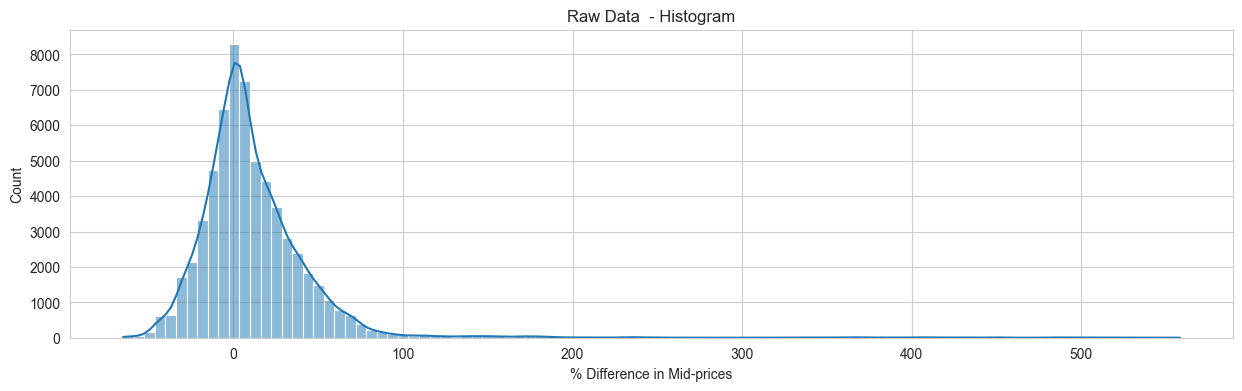

In [40]:
plt.figure(figsize=(15, 4))
sns.histplot(df_pct_diff.values.flatten(), bins=100, kde=True)
plt.title(f'{"Raw Data"}  - Histogram')
plt.xlabel("% Difference in Mid-prices")
plt.show()

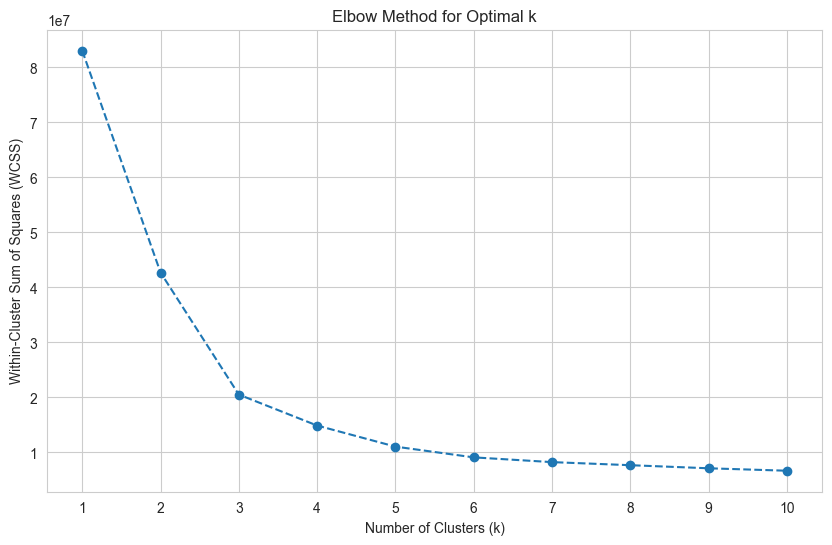

In [41]:
# Implement the Elbow Method
wcss = []  # Within-cluster sum of squares
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pct_diff)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)

In [42]:
# Step 4: Clustering Algorithms
from sklearn.cluster import Birch

# Choose optimal k based on the elbow (assume 4 here)
optimal_k = 5

# Fit clustering models
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(df_pct_diff)
gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(df_pct_diff)
dbscan = DBSCAN(eps=2.5, min_samples=3).fit(df_pct_diff)
agglo = AgglomerativeClustering(n_clusters=optimal_k).fit(df_pct_diff)
birch = Birch(n_clusters=optimal_k).fit(df_pct_diff)

# Step 5: Evaluation Metrics
def evaluate_clustering(data, labels, name):
    if len(set(labels)) <= 1:
        print(f"{name} clustering resulted in 1 or fewer clusters. Skipping metrics.\n")
        return
    print(f"Results for {name}:")
    print(f"Silhouette Score (Higher is better): {silhouette_score(data, labels):.3f}")
    print(f"Davies-Bouldin Index (Lower is better): {davies_bouldin_score(data, labels):.3f}")
    print(f"Calinski-Harabasz Score (Higher is better): {calinski_harabasz_score(data, labels):.3f}\n")

evaluate_clustering(df_pct_diff, kmeans.labels_, "KMeans")
evaluate_clustering(df_pct_diff, gmm.predict(df_pct_diff), "GMM")
evaluate_clustering(df_pct_diff, dbscan.labels_, "DBSCAN")
evaluate_clustering(df_pct_diff, agglo.labels_, "Agglomerative")
evaluate_clustering(df_pct_diff, birch.labels_, "Birch")

# Step 6: Visualize stock trends by cluster
def plot_clusters_trend(df, labels, title_prefix):
    df_copy = df.copy()
    df_copy['Cluster'] = labels
    for cluster_id in sorted(df_copy['Cluster'].unique()):
        cluster_members = df_copy[df_copy['Cluster'] == cluster_id].drop(columns='Cluster')
        plt.figure(figsize=(14, 5))
        for i in range(len(cluster_members)):
            plt.plot(cluster_members.columns, cluster_members.iloc[i], alpha=0.4)
        plt.title(f"{title_prefix} - Cluster {cluster_id} Trends")
        plt.title(f"{title_prefix} - Cluster {cluster_id} Trends")
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()


Results for KMeans:
Silhouette Score (Higher is better): 0.271
Davies-Bouldin Index (Lower is better): 0.924
Calinski-Harabasz Score (Higher is better): 135.152

Results for GMM:
Silhouette Score (Higher is better): 0.271
Davies-Bouldin Index (Lower is better): 0.924
Calinski-Harabasz Score (Higher is better): 135.152

DBSCAN clustering resulted in 1 or fewer clusters. Skipping metrics.

Results for Agglomerative:
Silhouette Score (Higher is better): 0.322
Davies-Bouldin Index (Lower is better): 0.737
Calinski-Harabasz Score (Higher is better): 151.312

Results for Birch:
Silhouette Score (Higher is better): 0.322
Davies-Bouldin Index (Lower is better): 0.737
Calinski-Harabasz Score (Higher is better): 151.312



# KMeans

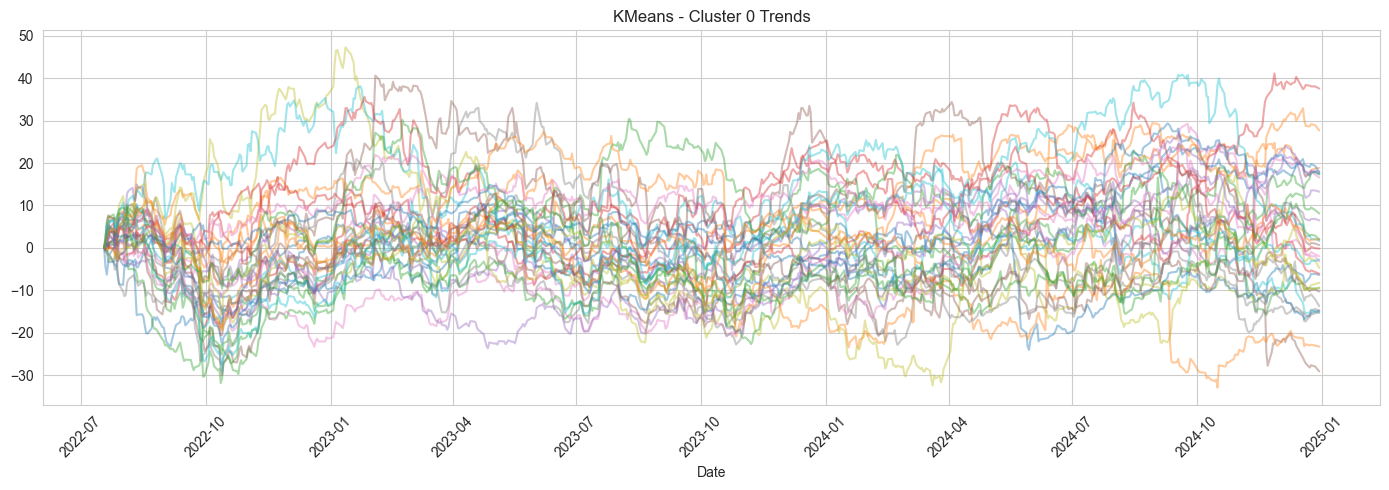

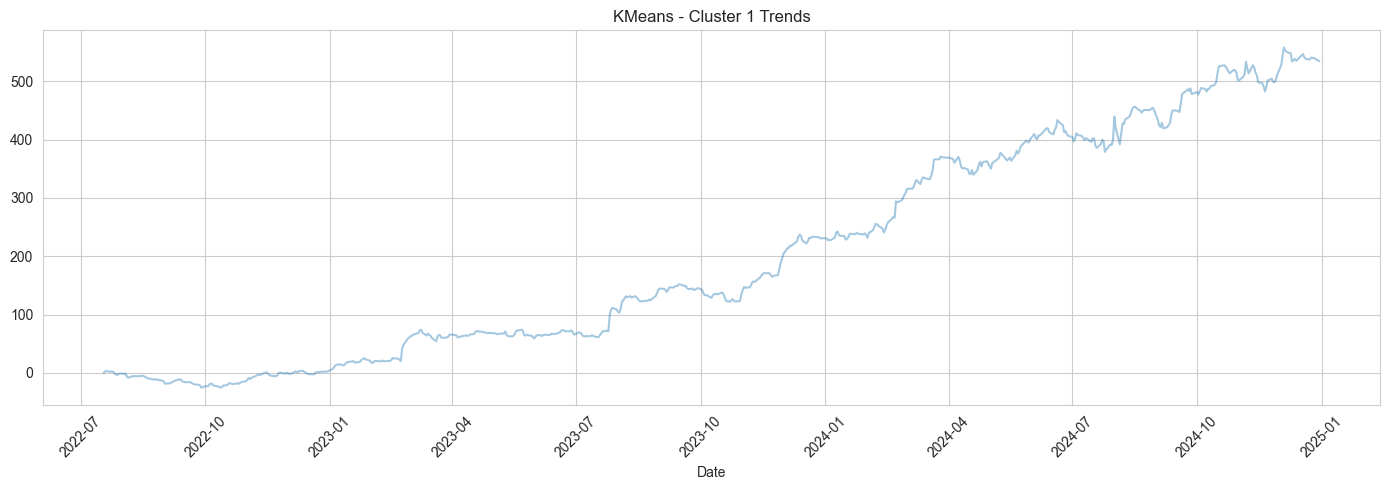

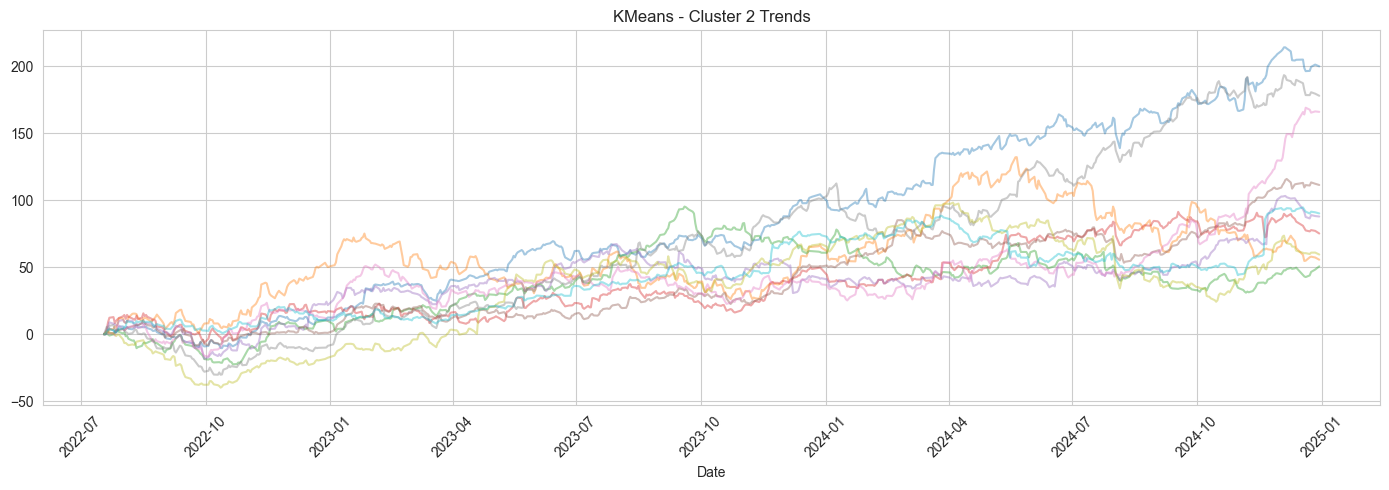

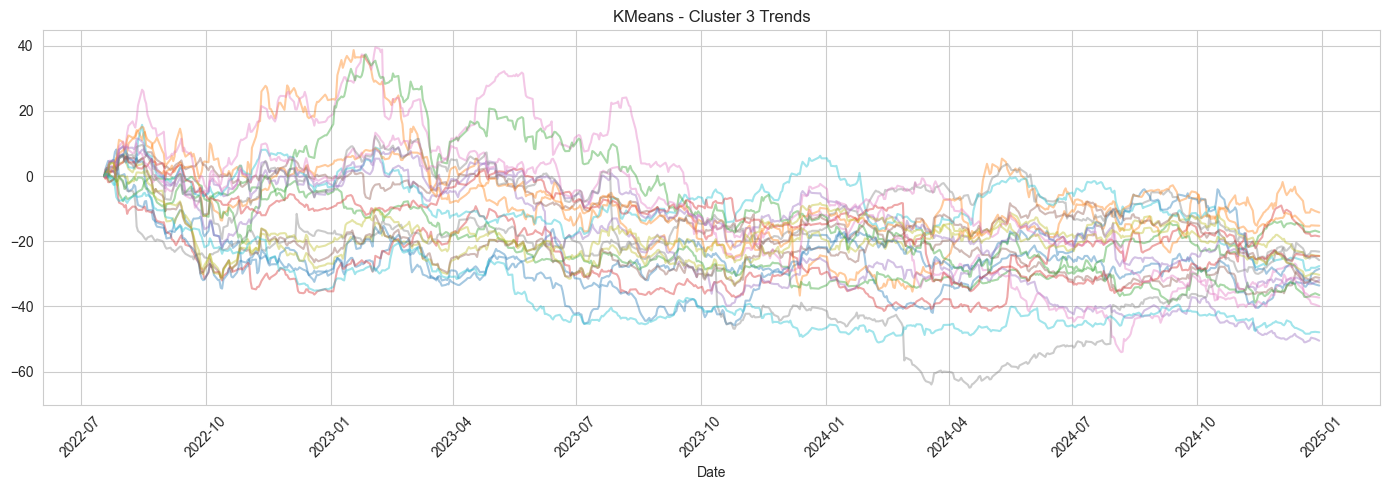

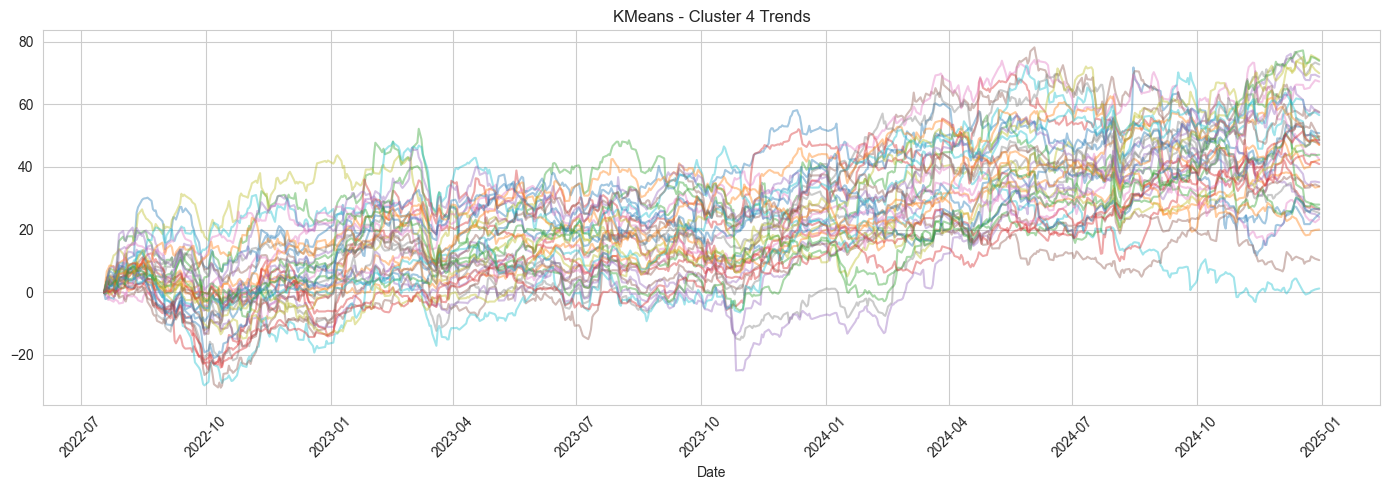

In [43]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, kmeans.labels_, "KMeans")

# Agglo

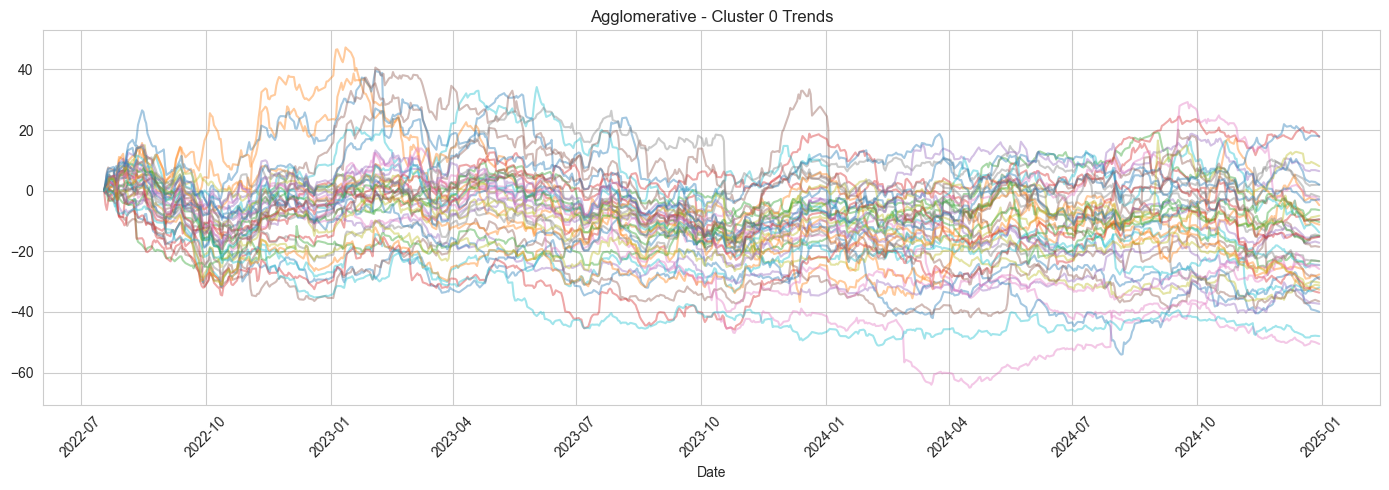

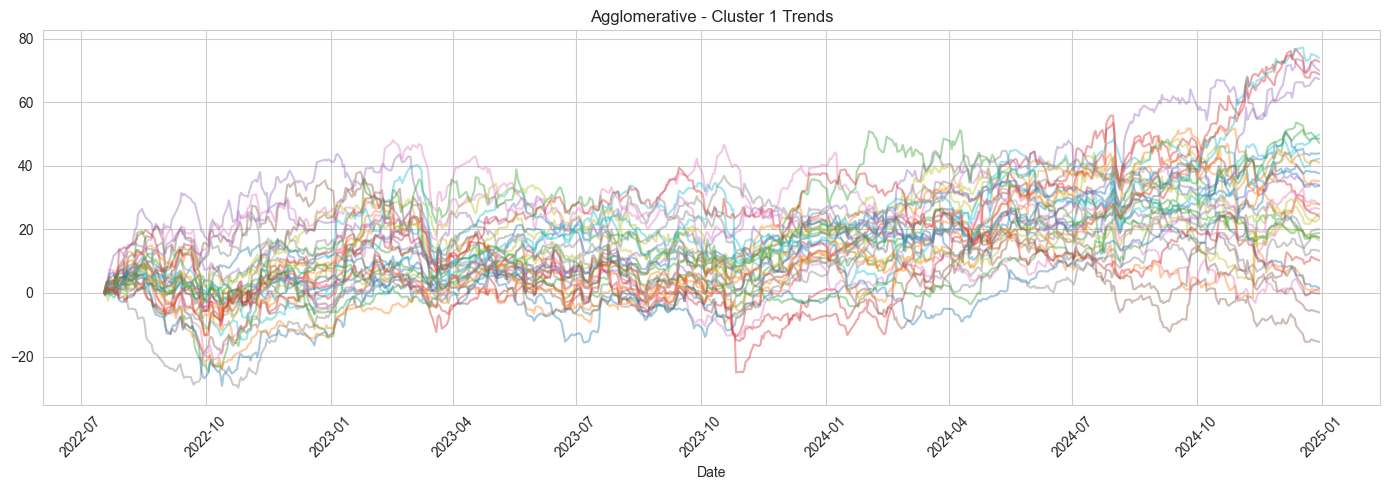

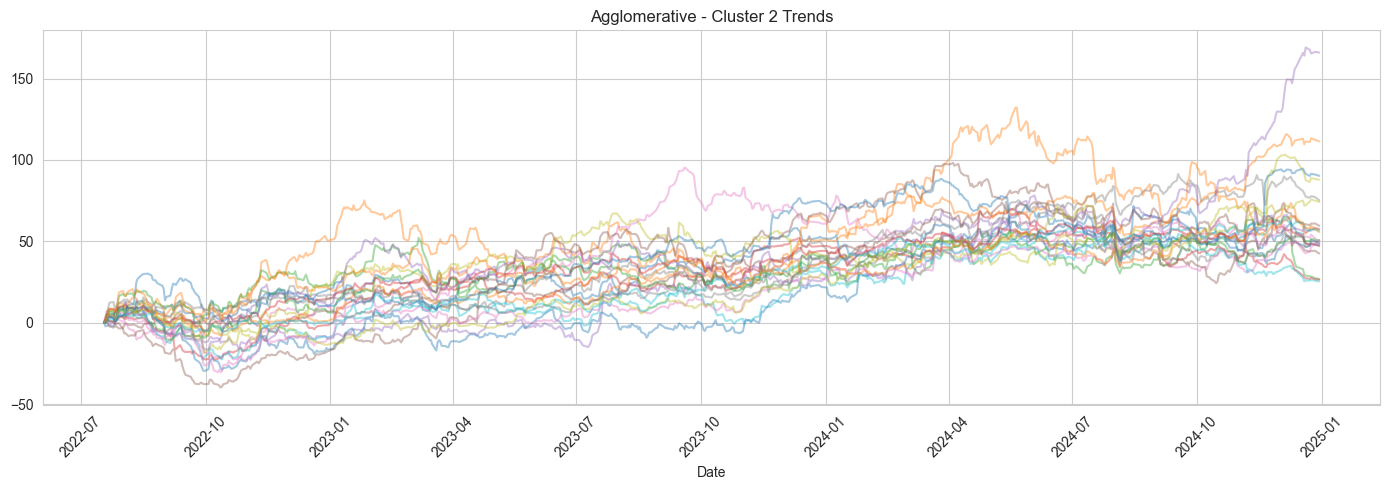

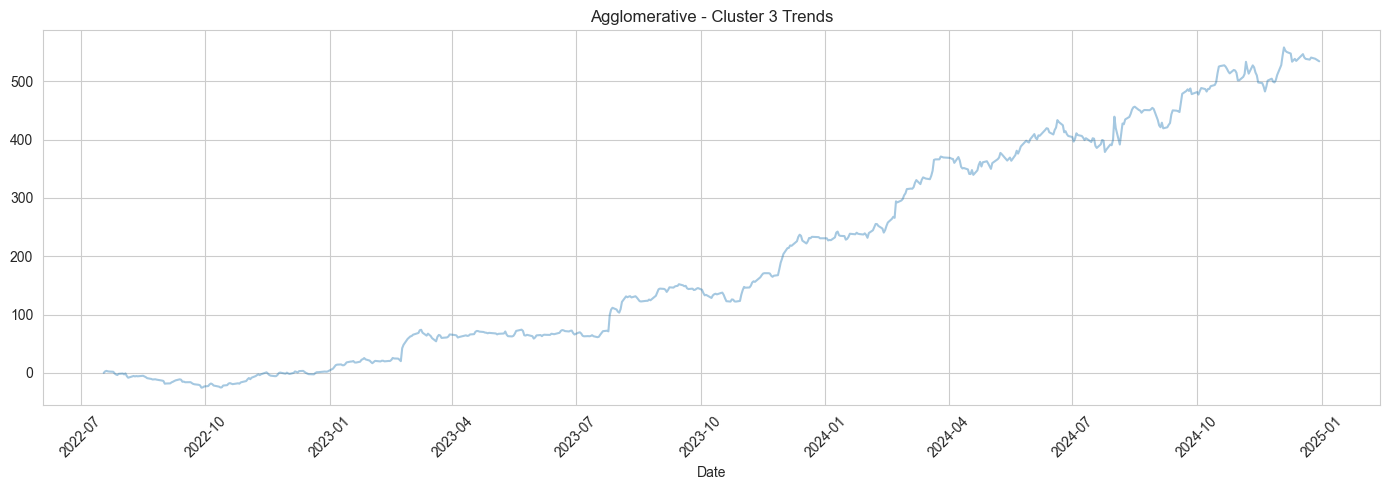

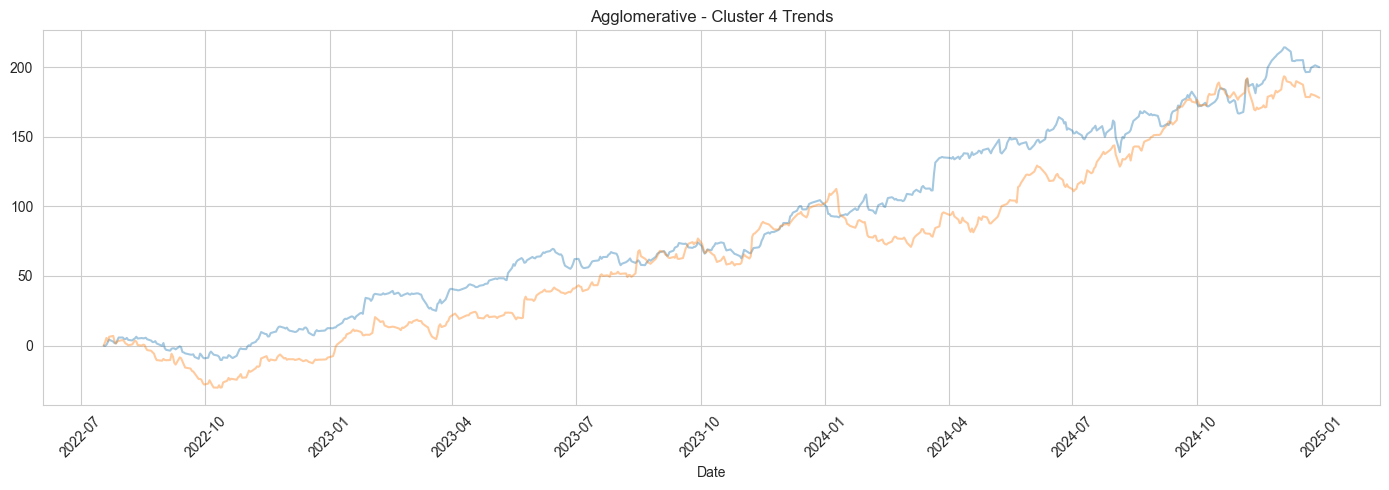

In [44]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, agglo.labels_, "Agglomerative")

# GMM

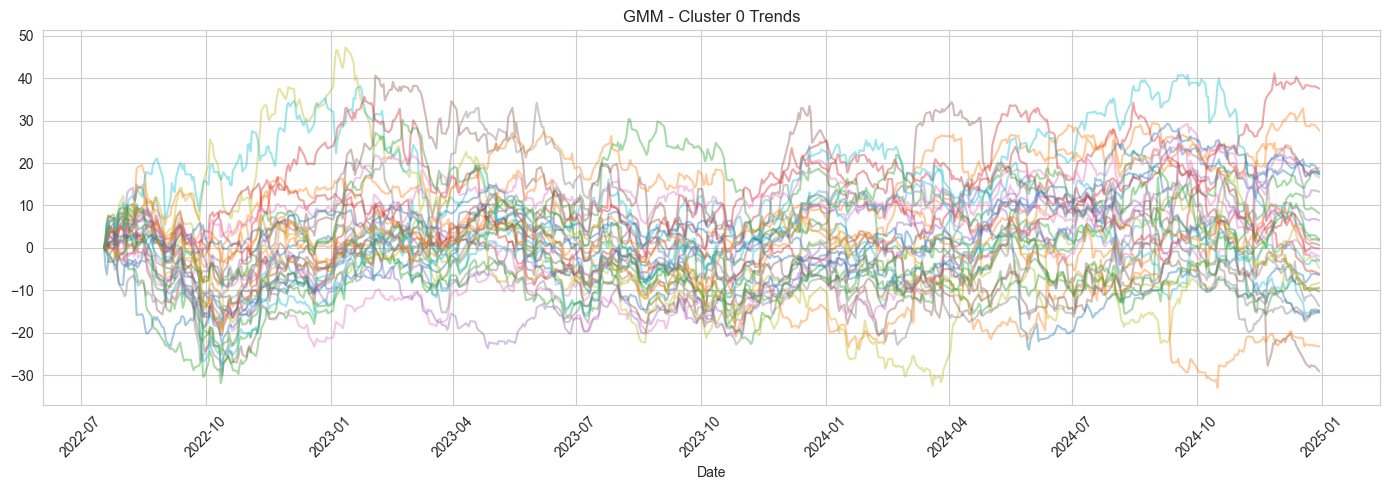

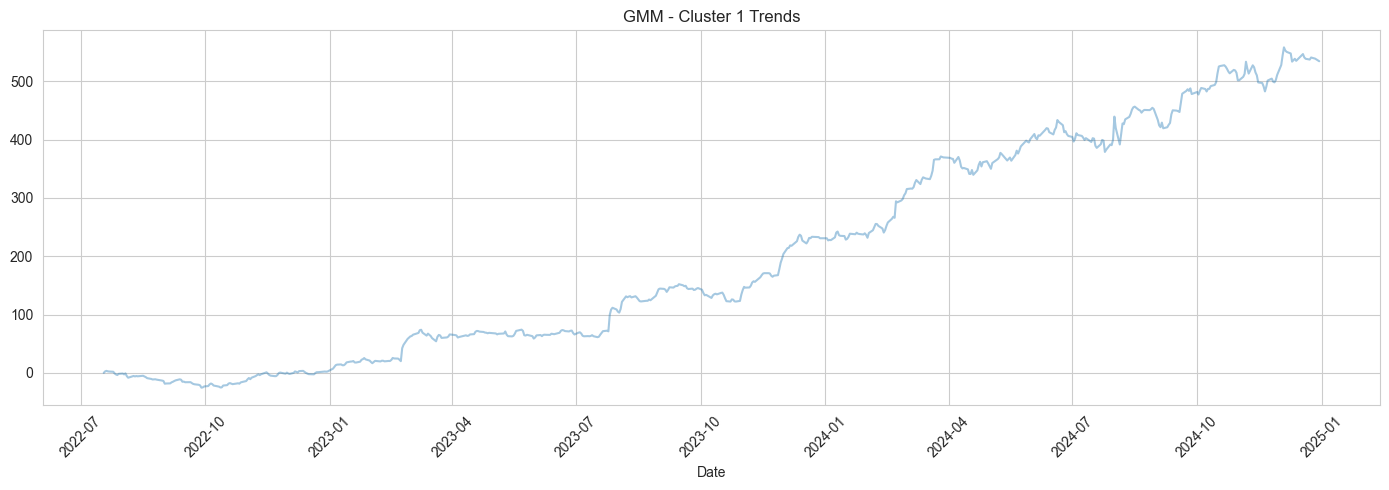

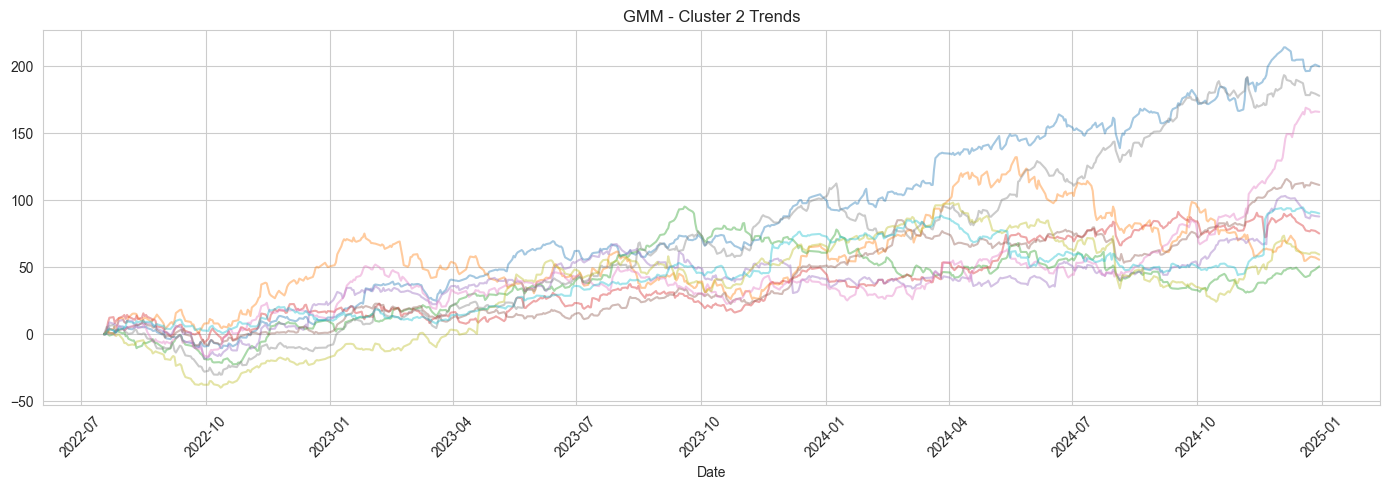

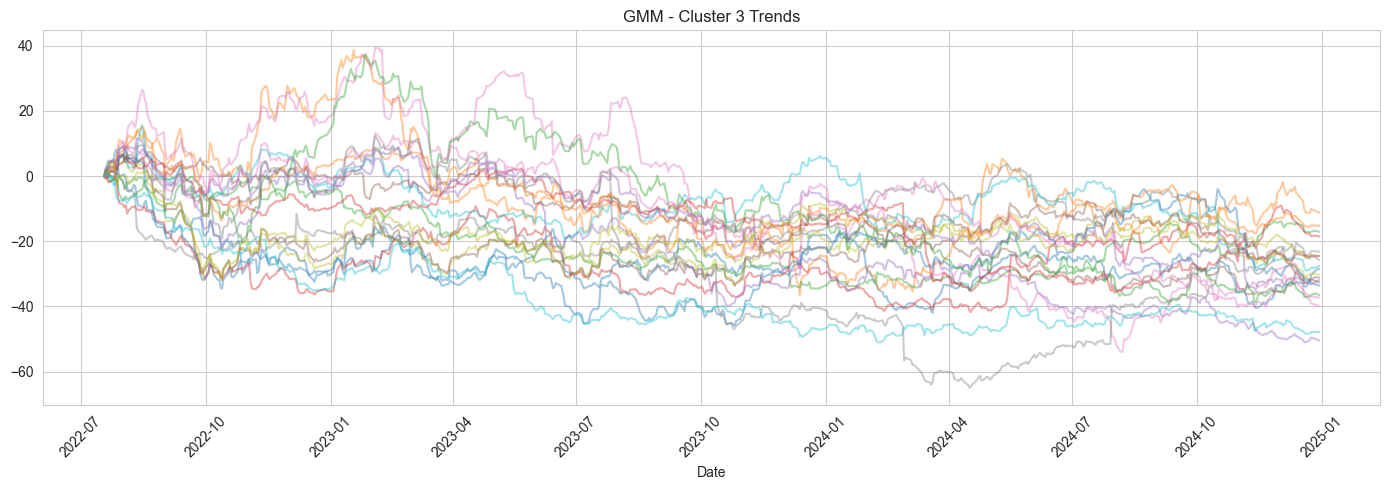

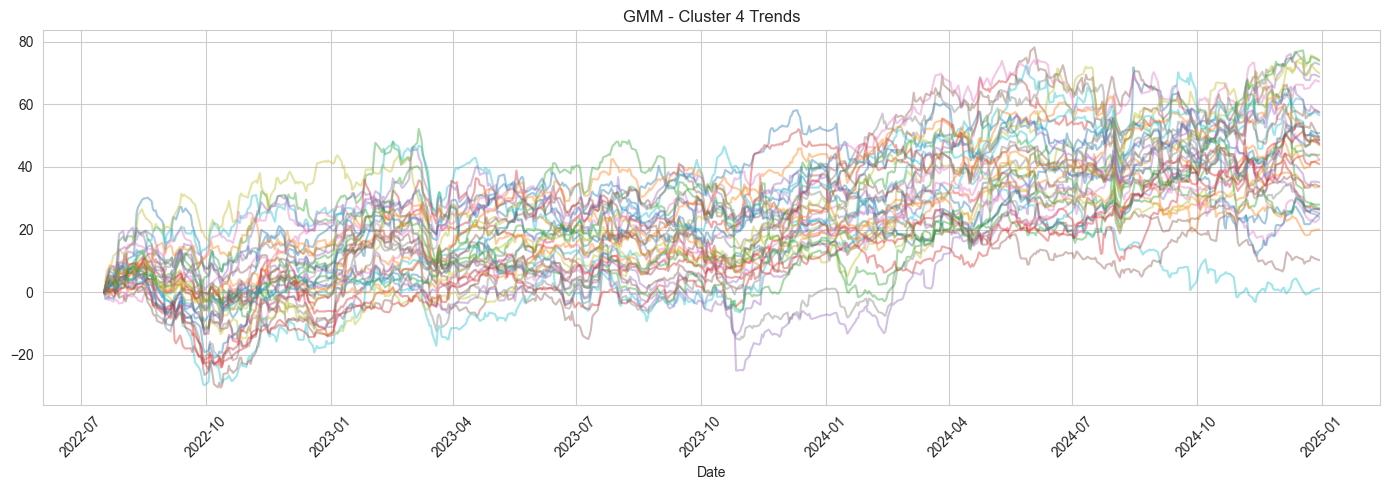

In [45]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, gmm.predict(df_pct_diff), "GMM")

# Birch

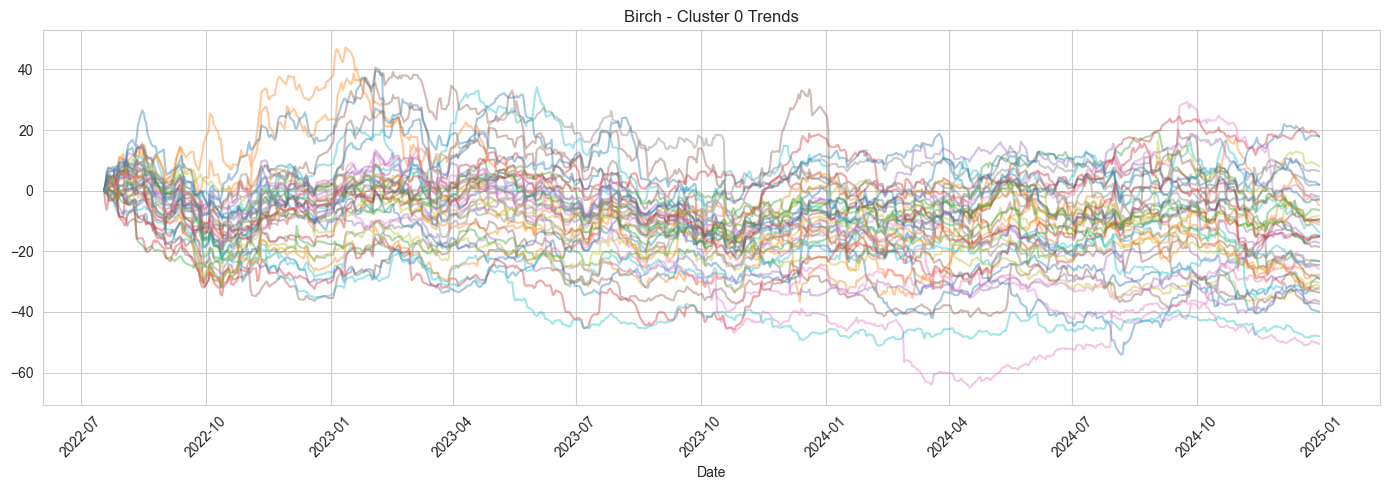

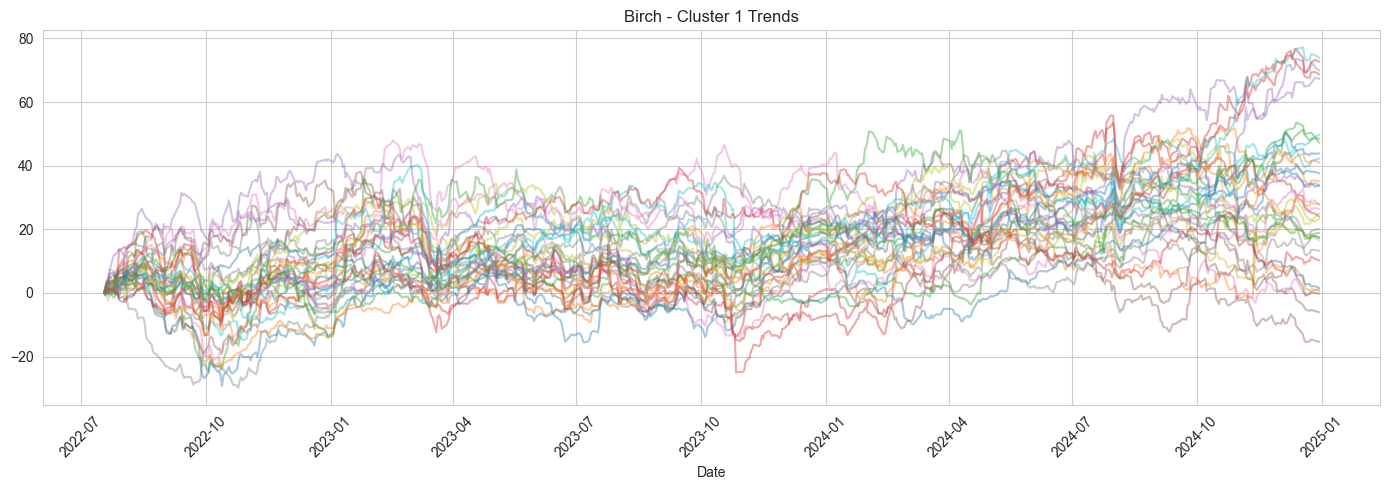

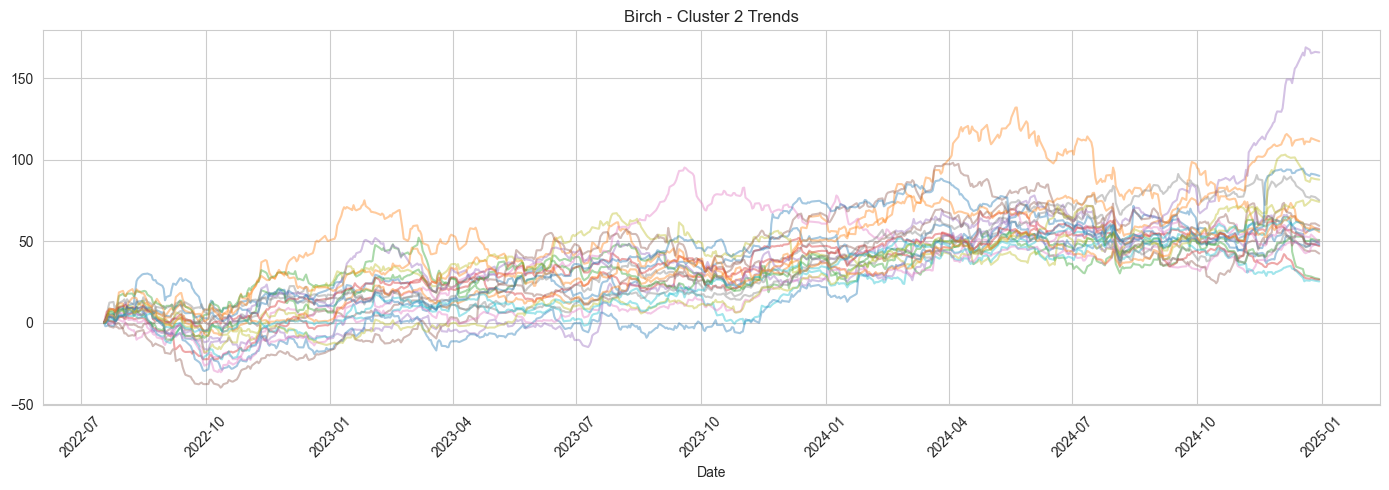

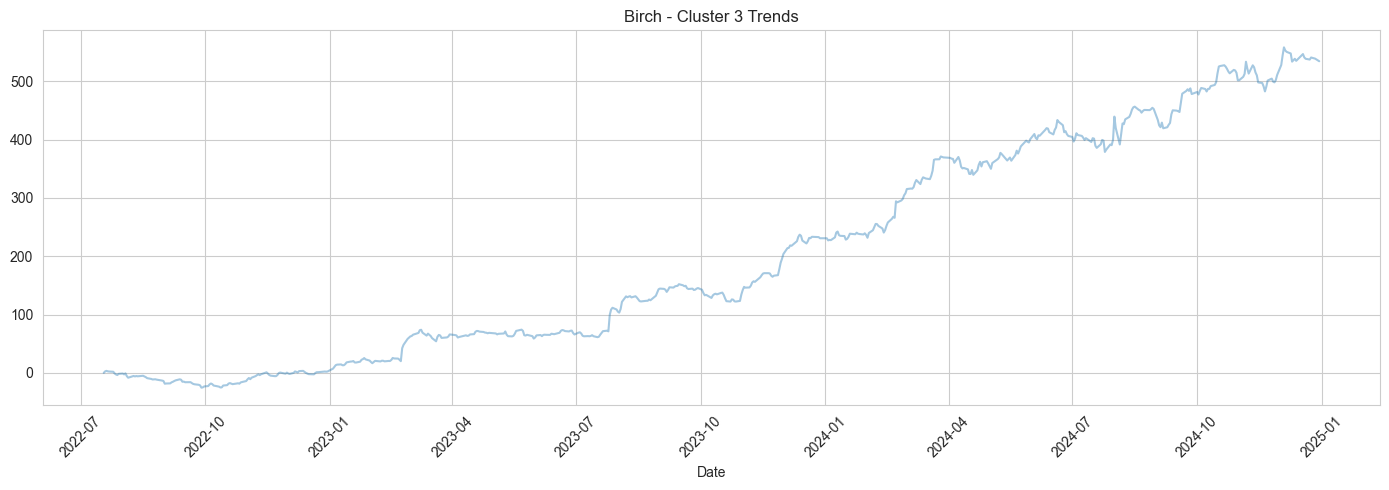

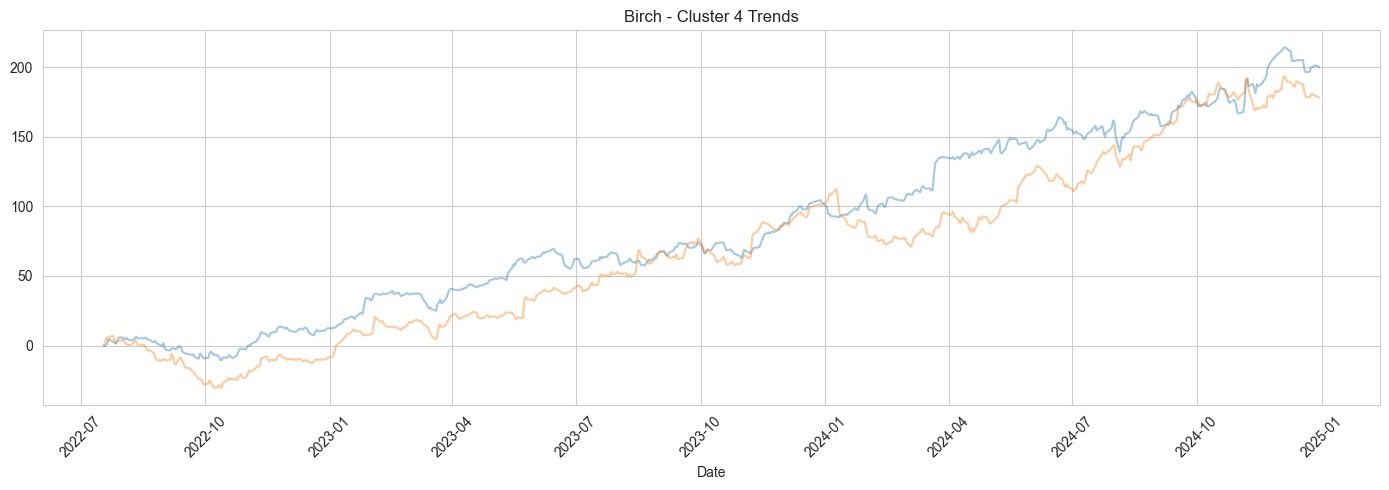

In [46]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, birch.labels_, "Birch")

# Cluster Visualization

In [47]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_pct_diff)

umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(df_pct_diff)

def plot_clusters_2D(X_proj, labels, method_name, reduction="t-SNE"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, palette='tab10', s=30)
    plt.title(f'{method_name} Clusters Visualized with {reduction}')
    plt.grid(True)
    plt.show()

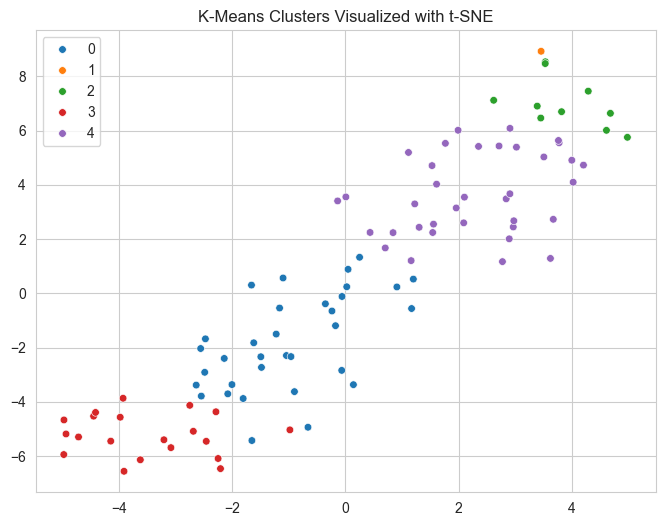

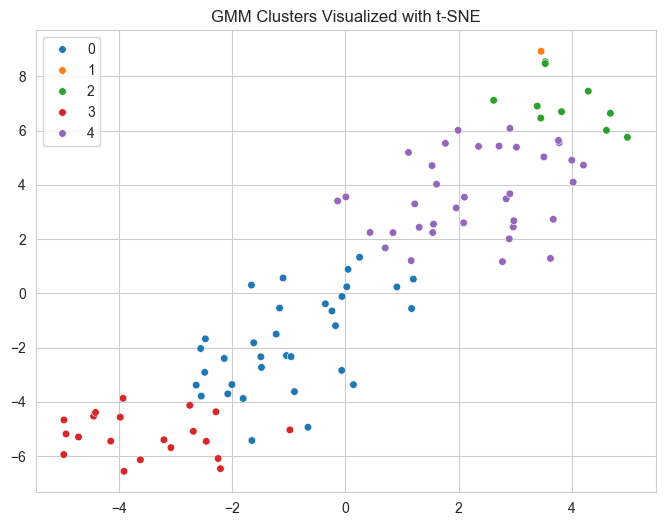

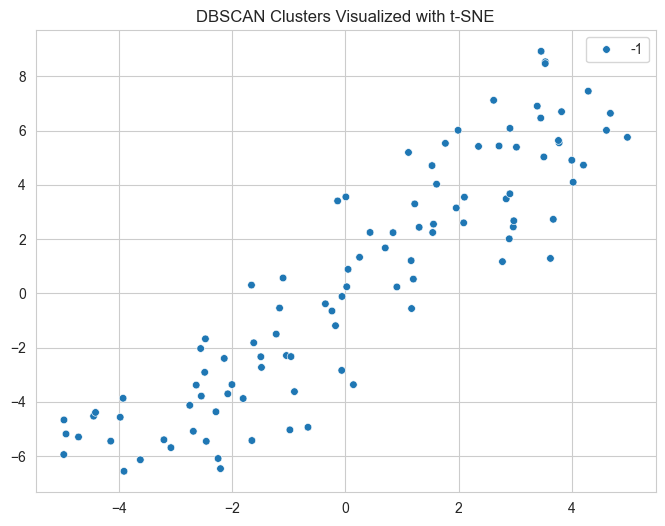

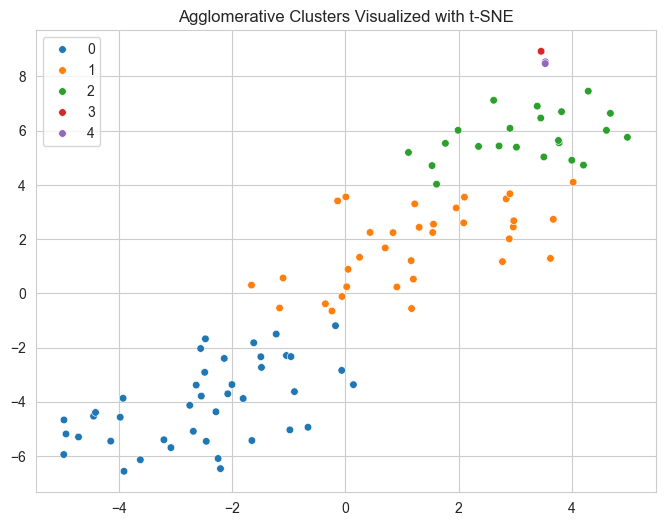

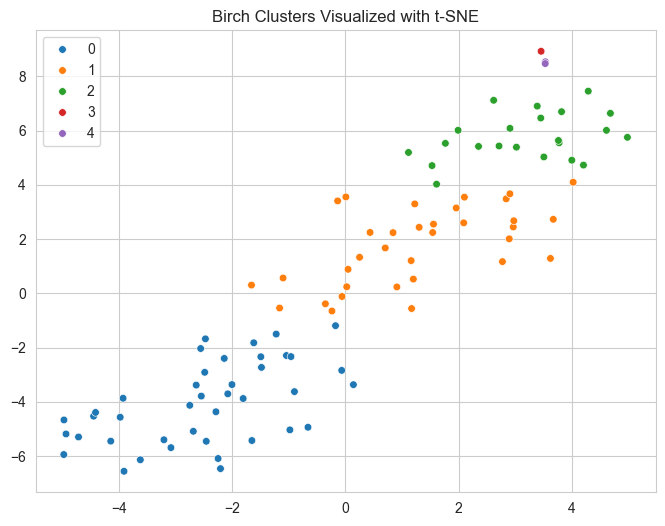

In [48]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "t-SNE")
plot_clusters_2D(X_tsne, gmm.predict(df_pct_diff), "GMM", "t-SNE")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "t-SNE")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "t-SNE")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "t-SNE")

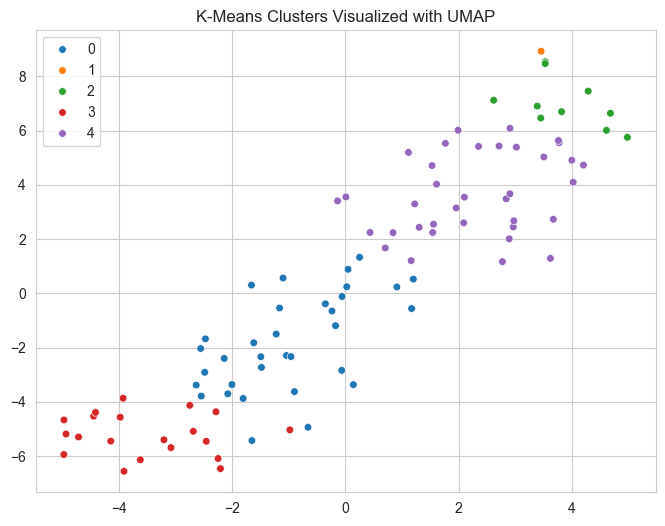

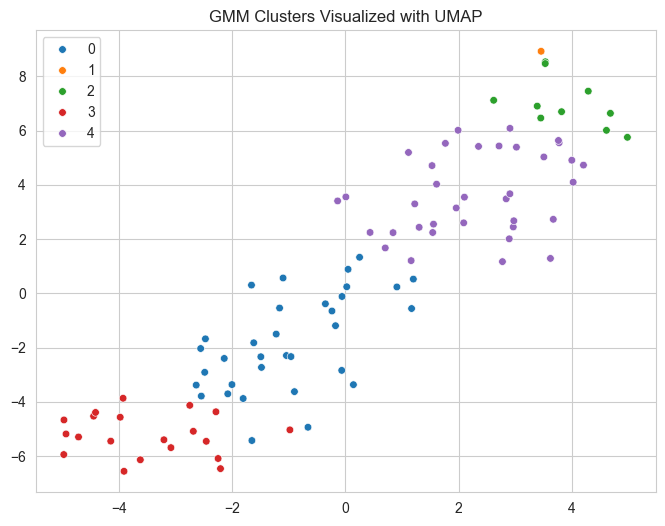

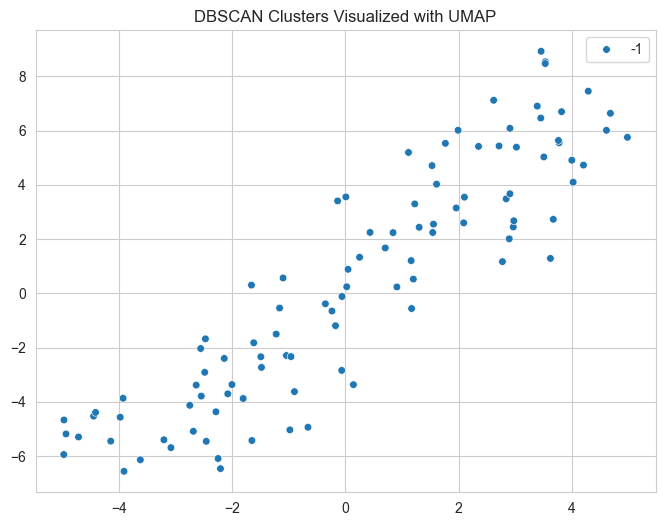

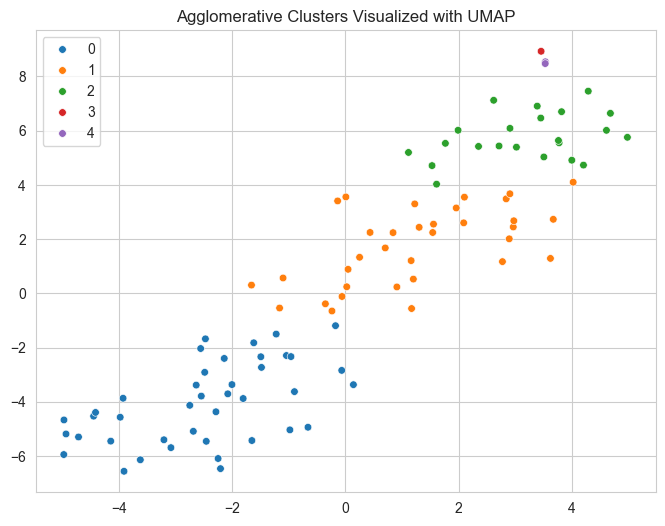

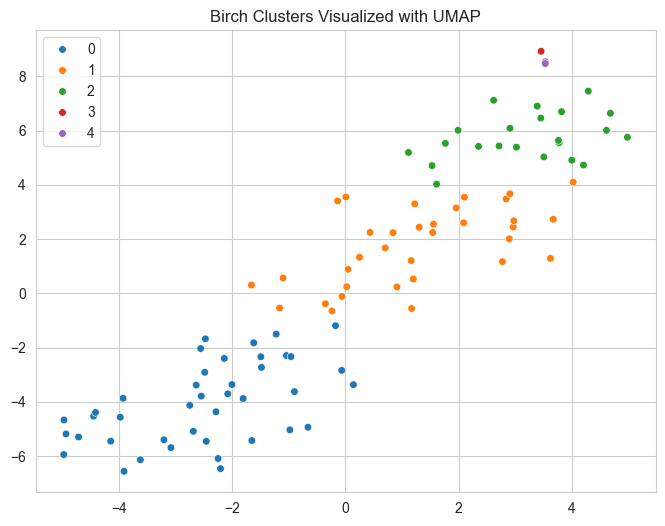

In [49]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "UMAP")
plot_clusters_2D(X_tsne, gmm.predict(df_pct_diff), "GMM", "UMAP")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "UMAP")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "UMAP")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "UMAP")

In [50]:
df_copy = df_pct_diff.copy()
df_copy["Cluster"] = birch.labels_

for cluster, tickers in df_copy.groupby('Cluster').apply(lambda x: list(x.index)).items():
    print(f"Cluster {cluster}: {', '.join(tickers)}")


Cluster 0: AAF.L, AAL.L, AZN.L, BTRW.L, BATS.L, BT-A.L, CRDA.L, DCC.L, DGE.L, EDV.L, ENT.L, FRES.L, GSK.L, HLN.L, ITRK.L, JD.L, KGF.L, LAND.L, LGEN.L, LMP.L, MNG.L, MNDI.L, NG.L, PSN.L, PHNX.L, PRU.L, RKT.L, RTO.L, RMV.L, SDR.L, SMT.L, SGRO.L, SVT.L, SN.L, SPX.L, SSE.L, STJ.L, UU.L, UTG.L, VOD.L, WPP.L
Cluster 1: ALW.L, AUTO.L, AV.L, BARC.L, BEZ.L, BKG.L, BP.L, BNZL.L, CCEP.L, CCH.L, CPG.L, CTEC.L, EZJ.L, EXPN.L, FCIT.L, GLEN.L, HLMA.L, HIK.L, HSX.L, HSBA.L, IMB.L, LLOY.L, LSEG.L, NWG.L, PSON.L, RIO.L, SBRY.L, SHEL.L, SMIN.L, STAN.L, TW.L, TSCO.L, ULVR.L, WTB.L
Cluster 2: ADM.L, ANTO.L, AHT.L, ABF.L, BAB.L, BA.L, CNA.L, DPLM.L, GAW.L, HWDN.L, ICG.L, IHG.L, IMI.L, INF.L, IAG.L, MRO.L, NXT.L, PSH.L, PCT.L, REL.L, SGE.L, WEIR.L
Cluster 3: RR.L
Cluster 4: III.L, MKS.L
